# Исследование сервиса аренды самокатов GoFast

Имеются данные от популярного сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках. 


**Вводные данные.**

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки:
        - абонентская плата - отсутствует;
        - стоимость одной минуты поездки —8 рублей;
        - стоимость старта (начала поездки) —50 рублей;

- с подпиской Ultra:
        - абонентская плата - есть, размер - 199 рублей в месяц;
        - стоимость одной минуты поездки —6 рублей;
        - стоимость старта - бесплатно.
        
**Цель исследования**: проверить гипотезы на основе данные, которые могут помочь бизнесу вырасти.

**План работы:**
- Загрузка и настройка библиотек
1. Загрузка набора данных

2. Изучение общей информации и выполнение предобработки данных:
- Чтение данных
- обработка пропусков
- удаление явных / неявных дубликактов
- приведение типа данных в соответствие с назначением
- Добавление в датафрейм необходимых для проведения исследования расчетных единиц.
3. Проведение исследовательского анализа данных. Опишем и визуализируем общую информацию о пользователях и поездках:
- описание каждого параметра
- поиск взаимосвязей между параметрами
- описание найденных ваимосвязей
- объединение данных о пользователях, поездках и поездках в один датафрейм.
- категоризация пользователей

4. Группировка информации по необходимым параметрам и объединение.
- визуализация получившейся информации. 

5. Исследование выручки по разным категориям пользователей.


6. Проверка гипотез для получения информации, необходимой для привлечения новых пользователей. 


7. Ответ на запрос о количестве промокодов и push-уведомлений.


8. Общий вывод

**Загрузка и настройка библиотек.**

In [1]:
# Датасеты
import pandas as pd
# Математика
import numpy as np
# Факториалы для комбинаторики
from math import factorial
# Статистика
from scipy import stats as st
from scipy.stats import binom
from math import sqrt

# Графики
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault

import seaborn as sns
# Копирование значений, а не ссылок, через b = copy.deepcopy(a)
import copy
# Обязательно для приемлимого отображения графиков plt
rcParams['figure.figsize'] = 10, 6
%config InlineBackend.figure_format = 'svg'
# доп. для декорирования графиков
factor = .8
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi * factor

## Изучение общей информации
### Загрузка занных.

Загрузим данные из cvs-файлов в датафрейм с помощью библиотеки pandas. Помимо пути директории укажем ссылку на исх.данные.

In [2]:
#пользователи
try:
    users_data = pd.read_csv('/datasets/users_go.csv', sep=',')
except:
    users_data = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv', sep=',')
users_data.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
#поездки
try:
    rides_data = pd.read_csv('/datasets/rides_go.csv', sep=',')
except:
    rides_data = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv', sep=',')
rides_data.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [4]:
#подписки
try:
    subscr_data = pd.read_csv('datasets/subscriptions_go.csv', sep=',')
except:
    subscr_data = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv', sep=',')
subscr_data.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [5]:
print(
    'Таблица о пользователях содержит', len(users_data), 'строк.\n\
Таблица о поездках содержит', len(rides_data), 'строк.\n\
Таблица о тарифах содержит', len(subscr_data), 'строки.\n\
Всего в трех таблицах содержится', len(users_data) + \
    len(rides_data) + len(subscr_data), 'строк.'
)

Таблица о пользователях содержит 1565 строк.
Таблица о поездках содержит 18068 строк.
Таблица о тарифах содержит 2 строки.
Всего в трех таблицах содержится 19635 строк.


### Итоги раздела.

Загружены три датафрейма, которые содержат конкретную информацию о пользователях и поездках. 
- Первый, информацию о пользователе: id пользователя, имя, возраст, город и данные о типе подписки. 
- Второй датафрейм, информацию о его поездках: id пользователя, дистанция, длительность и время поездки.
- Третий датасет содержит конкретные данные о подписке: стоимость абонентской платы, тариф за минуту и стоиомсть старта поездки, название подписки. 

Предварительно можно утверждать, что предоставленного объема данных достаточно для исследования и проверки гипотез. 

В выборку попало  1534 строк о конкретных пользователях, 18068 строк о их поездках.
Таблица о тарифах содержит 2 строки с данными о тарифах пользователей.

Всего в трех таблицах содержится 19604 строк

Для дальнейшего анализа проведем предобработку данных.

##  Выполнение предобработки данных
### users_data - таблица данных о пользователях.


In [6]:
display(users_data.sample(3))
print()
print('Cводная информация о таблице "пользователи":\n ')
print(users_data.info())
print()
print(
    'Датафрейм users_data содержит', \
    len(users_data), \
    'строк;\nколичество явных дубликатов в users_data =', \
    users_data.duplicated().sum(), 'шт.;'\
    '\nколичество пропусков в users_data = ',\
    users_data.isnull().values.sum(), '.'
     )

,user_id,name,age,city,subscription_type
579,580,Вероника,31,Пятигорск,ultra
1540,127,Павел,25,Пятигорск,ultra
568,569,Роберт,32,Екатеринбург,ultra



Cводная информация о таблице "пользователи":
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None

Датафрейм users_data содержит 1565 строк;
количество явных дубликатов в users_data = 31 шт.;
количество пропусков в users_data =  0 .


In [7]:
users_data.drop_duplicates(inplace=True)

print('После удаления явных дубликатов в users_data, их количество =', \
    users_data.duplicated().sum(), 'шт.;'
     )

После удаления явных дубликатов в users_data, их количество = 0 шт.;


### subscr_data - таблица данных о подписках.

In [8]:
display(subscr_data.head())
print('Cводная информация о таблице "подписки":\n ')
print(subscr_data.info())
print()
print(
    'Датафрейм subscr_data содержит', \
      len(subscr_data), \
    'строк;\nколичество явных дубликатов в subscr_data =', \
     subscr_data.duplicated().sum(), 'шт.;'\
    '\nколичество пропусков в subscr_data = ',\
      subscr_data.isnull().values.sum(), '.'
     )

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Cводная информация о таблице "подписки":
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None

Датафрейм subscr_data содержит 2 строк;
количество явных дубликатов в subscr_data = 0 шт.;
количество пропусков в subscr_data =  0 .


### rides_data - таблица данных о поездках.

In [9]:
display(rides_data.sample(3))
print('Cводная информация о таблице "поездки":\n ')
print(rides_data.info())
print()
print(
    'Датафрейм rides_data содержит', \
      len(rides_data), \
    'строк;\nколичество явных дубликатов в rides_data =', \
      rides_data.duplicated().sum(), 'шт.;'\
    '\nколичество пропусков в rides_data = ',\
      rides_data.isnull().values.sum(), '.'
     )

,user_id,distance,duration,date
6561,704,4959.677524,26.838710,2021-06-03
2252,241,2851.973675,12.111372,2021-04-17
12776,1159,4047.021474,12.373148,2021-01-24


Cводная информация о таблице "поездки":
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None

Датафрейм rides_data содержит 18068 строк;
количество явных дубликатов в rides_data = 0 шт.;
количество пропусков в rides_data =  0 .


In [10]:
# приведение типа данных в столбце 'date' к типу данных даты
rides_data['date'] = pd.to_datetime(rides_data['date'], format='%Y-%m-%d')
print(rides_data.head())
print('\nПосле преобразования в столбце date  тип данных - ', rides_data['date'].dtypes)

   user_id     distance   duration       date
0        1  4409.919140  25.599769 2021-01-01
1        1  2617.592153  15.816871 2021-01-18
2        1   754.159807   6.232113 2021-04-20
3        1  2694.783254  18.511000 2021-08-11
4        1  4028.687306  26.265803 2021-08-28

После преобразования в столбце date  тип данных -  datetime64[ns]


Для удобства восприятия данных округлим значения с помощью метода "потолок" в колонках:

- distance - дистанция до метров, т.е. до целых чисел, 
- duration - продолжительность поездки - значения округлим до целых минут.

Типы данных в этих колонках после округления преобразуем в целочисленный int.

In [11]:
rides_data['distance'] = rides_data['distance'].apply(np.ceil).astype(int)
rides_data['duration'] = rides_data['duration'].apply(np.ceil).astype(int)
print(rides_data.head())
print('\nПосле преобразования тип данных - в столбцах:\n\
- distance:  ', rides_data['distance'].dtypes,\
'\n- duration: ', rides_data['duration'].dtypes\
     )

   user_id  distance  duration       date
0        1      4410        26 2021-01-01
1        1      2618        16 2021-01-18
2        1       755         7 2021-04-20
3        1      2695        19 2021-08-11
4        1      4029        27 2021-08-28

После преобразования тип данных - в столбцах:
- distance:   int64 
- duration:  int64


Выведем минимальную и максимальную даты из датафрема, чтобы посмотеть в пределах скольки лет даны данные для анализа.
Добавим новый столбец в датафрейм rides_data с данными о месяце поездки - 'date_month', для этого поместим столбец дату в класс DatetimeIndex  и применим к нему атрибут month.

In [12]:
print ('\nПервая дата:', \
       rides_data['date'].min())
print ('Последняя дата:',\
       rides_data['date'].max(), '\n')

rides_data['date_month'] = pd.DatetimeIndex(rides_data['date']).month
print(rides_data.sample(3))


Первая дата: 2021-01-01 00:00:00
Последняя дата: 2021-12-30 00:00:00 

      user_id  distance  duration       date  date_month
841        90      3696        21 2021-12-11          12
9187      900      5505        28 2021-05-01           5
2426      259      2867        27 2021-01-26           1


### **ИТОГИ РАЗДЕЛА**

В основных данных есть информация о пользователях, их поездках и подписках. Разберём, какие в таблицах столбцы, и какую информацию они содержат, опишем их.
 
#### **Описание данных:**

**Пользователи —  загружены данные в датафрейм - users_data**

- user_id - уникальный идентификатор пользователя
- name - имя пользователя
- age -возраст
- city - город
- subscription_type - тип подписки (free, ultra)

**Поездки — загружены данные в датафрейм - rides_data**

- user_id - уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки

**Подписки — загружены данные в датафрейм subscr_data**

- subscription_type -тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price -стоимость начала поездки
- subscription_fee -стоимость ежемесячного платежа 

#### Информация по датафреймам:

- Датафрейм users_data 

    - содержит 1565 строк;
    - количество явных дубликатов в users_data = 31 шт.;
    - количество пропусков в users_data =  0 .

- Датафрейм rides_data 

    - содержит 18068 строк;
    - количество явных дубликатов в rides_data = 0 шт.;
    - количество пропусков в rides_data =  0 .

- Датафрейм subscr_data 

    - содержит 2 строк;
    - количество явных дубликатов в subscr_data = 0 шт.;
    - количество пропусков в subscr_data =  0 .

#### Предобработка даных.

В датафрейме subscr_data  в столбце 'date' тип данных заменен на типу данных datetime.

Удалены явные дубликаты в users_data в количестве = 31 шт.

Для удобства восприятия данных округлили значения с помощью метода "потолок" в колонках :

- distance - дистанция до метров, т.е. до целых чисел, 
- duration - продолжительность поездки - значения округлим до целых минут.

Типы данных в этих колонках после округления преобразованы в целочисленные - тип int64.

Добавлен новый столбец в датафрейм rides_data с данными о месяце поездки - 'date_month'. Все поездки осуществлены в пределах одного 2021 года.

## Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках:
 - частота встречаемости городов;
 - соотношение пользователей с подпиской и без подписки;
 - возраст пользователей;
 - расстояние, преодоленное пользователем за одну поездку;
 - продолжительность поездок.


In [13]:
users_data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1534.0,767.50000,442.971971,1.0,384.25,767.5,1150.75,1534.0
age,1534.0,24.90352,4.572367,12.0,22.00,25.0,28.00,43.0


In [14]:
rides_data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,18068.0,842.869936,434.734317,1.0,487.00,889.0,1213.25,1534.0
distance,18068.0,3071.159841,1116.831548,1.0,2543.75,3134.0,3777.00,7212.0
duration,18068.0,18.303520,6.094928,1.0,14.00,18.0,22.00,41.0
date_month,18068.0,6.486772,3.437410,1.0,4.00,6.0,9.00,12.0


### Частота встречаемости городов или количество пользователей по городам.



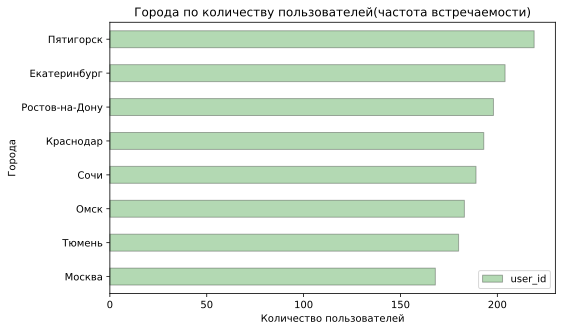

Рейтинг городов по частоте встречаемости (количеству пользователей):


,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [15]:
(
    users_data.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=True)
    .plot.barh(figsize=(8,5), alpha=0.3, color='green', ec='black', linewidth=1)
);

plt.title('Города по количеству пользователей(частота встречаемости)')
plt.ylabel('Города')
plt.xlabel('Количество пользователей')
plt.show()

print('Рейтинг городов по частоте встречаемости (количеству пользователей):') 
users_data.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)

Вывод:
На основании визуализации и сортировки данных по частоте встречаемости городов (количеству пользоватетей), можно увидеть, что

- Пятигорск - лидер, что не удивительно, ведь город весьма холмистый;
- Екатеринбург - занимает второе место по частоте упоминаний, что примечательно, рельеф города характеризуется чередованием низкогорья и холмистых равнин;
- Москва - на последнем месте.

### Cоотношение пользователей с подпиской и без подписки.

Визуализируем на графике пользователей по типу подписки:

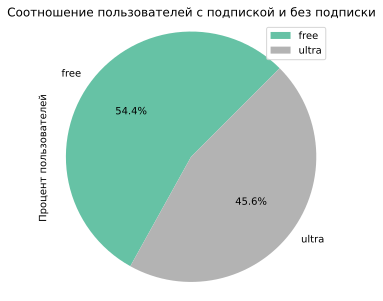

In [16]:
(
    users_data.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
    .plot.pie(y='user_id', figsize=(5,5),  colormap='Set2', label='Процент пользователей', 
    autopct='%1.1f%%', startangle=45,
    title='Cоотношение пользователей с подпиской и без подписки')

)
plt.axis('equal')
plt.show()

In [17]:
ultra_users = users_data[users_data['subscription_type'] == 'ultra']['subscription_type'].count()
free_users = users_data[users_data['subscription_type'] == 'free']['subscription_type'].count()
print('Всего пользователей:', ultra_users + free_users, 'чел., из них:\n'
      '- пользователей с подпиской: ', ultra_users, 'чел. или ', \
      round(ultra_users / (ultra_users + free_users) * 100, 1), '% от общего числа пользователей;\n'\
      '- пользователей без подписки:',free_users, 'чел. или ',\
      round(free_users / (ultra_users + free_users) * 100, 1), '% от общего числа пользователей.\n'\
     )           

Всего пользователей: 1534 чел., из них:
- пользователей с подпиской:  699 чел. или  45.6 % от общего числа пользователей;
- пользователей без подписки: 835 чел. или  54.4 % от общего числа пользователей.



In [18]:
if free_users > ultra_users:
    print('\nКоличество пользователей без подписки превышает количество пользователей с подпиской на',\
          round(
               (round(free_users / (ultra_users + free_users) * 100, 1)) -\
               (round(ultra_users / (ultra_users + free_users) * 100, 1)), 2), \
                 '%.'
                )
else:
    if ultra_users > free_users:
           print('\nКоличество пользователей c подпиской превышает количество пользователей без подписки на',\
           round(
               (round(ultra_users / (ultra_users + free_users) * 100, 1)) -\
               (round(free_users / (ultra_users + free_users) * 100, 1)), 2), \
                 '%.'
                )   


Количество пользователей без подписки превышает количество пользователей с подпиской на 8.8 %.


### Cоотношение пользователей по возрасту

Посмотрим на диаграмму пользователей отсортированную по возрастам.

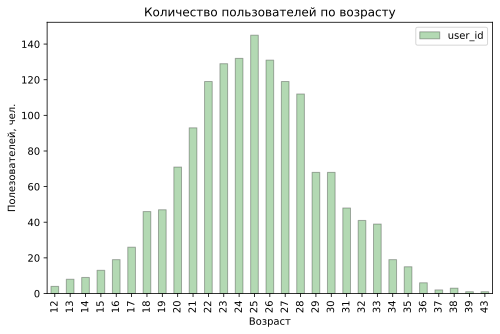

Средний возраст пользователя 25.0


count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [19]:
(
    users_data.pivot_table(index='age', values='user_id', aggfunc='count').sort_values(by='age', ascending=True)
    .plot.bar(figsize=(8,5), alpha=0.3, color='green', ec='black', linewidth=1)
);

plt.title('Количество пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Полезователей, чел.')
plt.show()
print('Средний возраст пользователя', users_data['age'].mean().round(0))
users_data['age'].describe()

**Вывод**: Визуализация распределения по возрасту пользователей показывает нормальное распределение. Средний и медианный возраст пользователя  совпадают и равны 25 годам.

Самыми младшими являются пользователи 12 лет.
Самыми старшими - 43 года.

В целом, возраст основных пользователей приложения от 22 лет до 28 лет. На это указывают значения первого квартиля и третьего квартиля данных.

### Расстояние, преодоленное пользователем за одну поездку. 
Выведем цифровую информацию по столбцу distance датафрейма rides_data. Затем отсортируем поездки по расстоянию, которое преодолели пользователи за одну поездку и посмотрим их соотношение на гистограмме.

In [20]:
rides_data['distance'].describe()

count    18068.000000
mean      3071.159841
std       1116.831548
min          1.000000
25%       2543.750000
50%       3134.000000
75%       3777.000000
max       7212.000000
Name: distance, dtype: float64

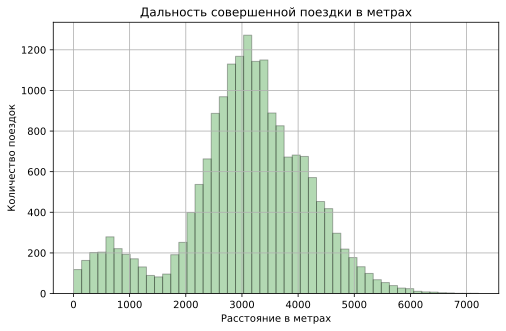

In [21]:
rides_data['distance'].describe()
(rides_data['distance']).hist(bins=50, figsize=(8,5), alpha=0.3, color='green', ec='black', linewidth=1);
plt.title('Дальность совершенной поездки в метрах')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.show()

Гистограмма показала наличие двух групп пользователей:
- первая группа меньше второй и она совершает короткие поездки от 1 до 1500 метров;
- вторая группа многочисленная - поездки совершаются на расстояния примерно от 1500 до 7212 метров максимально.

Пик поездок приходится на поездки чуь более 3000 метров. Цифровое описание данных показывает медиану на отметке 3134 метров.

Если рассматривать две эти группы обособленно, то можно считать, что распределение зависимости у каждой группы нормальное.


Для всех пользователей медиана дальности поездки равна 3134, а среднее 3071. В целом, дальность поездок от 2543 метров  до 3777 метров.  На это указывают значения первого квартиля и третьего квартиля данных.

### Продолжительность поездок

In [22]:
rides_data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,18068.0,842.869936,434.734317,1.0,487.00,889.0,1213.25,1534.0
distance,18068.0,3071.159841,1116.831548,1.0,2543.75,3134.0,3777.00,7212.0
duration,18068.0,18.303520,6.094928,1.0,14.00,18.0,22.00,41.0
date_month,18068.0,6.486772,3.437410,1.0,4.00,6.0,9.00,12.0


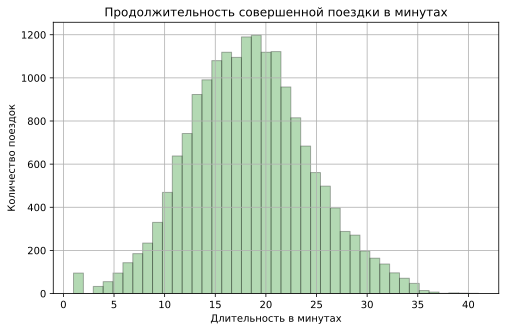

In [23]:
(rides_data['duration']).hist(bins=41, figsize=(8,5), alpha=0.3, color='green', ec='black', linewidth=1, grid=True);
plt.title('Продолжительность совершенной поездки в минутах')
plt.xlabel('Длительность в минутах')
plt.ylabel('Количество поездок')
plt.show()

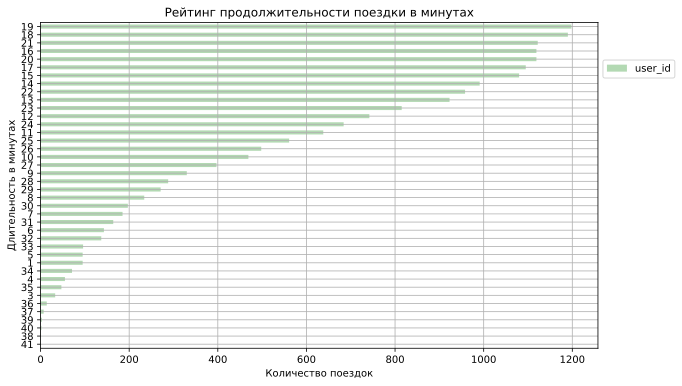

Средняя продолжительность поездки 18.0 мин.
Медианная продолжительность поездки 18.0 мин. 
Самая длительная поездка 41 мин.



count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

In [24]:
(
    rides_data.pivot_table(
        index='duration', 
        values='user_id', 
        aggfunc='count'
    ).sort_values(by='user_id', ascending=True)
    .plot.barh(figsize=(10,6), alpha=0.3, color='green', linewidth=1, grid=True)
);
plt.legend(bbox_to_anchor=(1, 0.9))
plt.title('Рейтинг продолжительности поездки в минутах')
plt.ylabel('Длительность в минутах')
plt.xlabel('Количество поездок')
plt.show()
print('Средняя продолжительность поездки', rides_data['duration'].mean().round(0), \
     'мин.\nМедианная продолжительность поездки', rides_data['duration'].median().round(0), 'мин.',\
     '\nСамая длительная поездка', rides_data['duration'].max(), 'мин.\n')
rides_data['duration'].describe()

По частоте совершения:
- первое место занимают поездки длительностью 19 или 18 минут;
- второе место разделили поездки длительностью 21, 16 и 20 минут;
- третье место поездки 17 минут.

Самая длительная поездка - 41 минута.

Короткие поездки  в одну минуту - почти 100. Вероятно пользователи отказались от поездки, либо возникла еще какая-то причина, по которой поездка по факту прекратилась едва успев начаться, например техническая неисправность самоката или приложения.

Для всех пользователей медианное и среднее время поездок равны 18 минутам. В целом, дальность поездок от 14 минут  до 22 минут На это указывают значения первого квартиля и третьего квартиля данных.

## Группировка информации по необходимым параметрам и объединение. 
Визуализация получившейся информации.

### Создадим датафреймы.
Воспользуемся методом merge() и Объединим данные о пользователях, поездках и подписках из датафреймов users_data, rides_data и subscr_data в один датафрейм, с названием data_merge. 
Посмотрим, по какой колонке можно их объединить.


In [25]:
print('Названия столбцов датафрейма users_data', list(users_data.columns))
print('Названия столбцов датафрейма rides_data', list(rides_data.columns))
print('Названия столбцов датафрейма subscr_data', list(subscr_data.columns))

Названия столбцов датафрейма users_data ['user_id', 'name', 'age', 'city', 'subscription_type']
Названия столбцов датафрейма rides_data ['user_id', 'distance', 'duration', 'date', 'date_month']
Названия столбцов датафрейма subscr_data ['subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']


Объединим данные в новый датафрейм с названием  data_merge: датафрейм **users_data**  - таблица к которой присоединим датафрейм **rides_data** по общему столбцу **'user_id'**, 

In [26]:
data_merge = users_data.merge(rides_data, on='user_id', how='left')
print(data_merge.head(3))

   user_id  name  age    city subscription_type  distance  duration  \
0        1  Кира   22  Тюмень             ultra      4410        26   
1        1  Кира   22  Тюмень             ultra      2618        16   
2        1  Кира   22  Тюмень             ultra       755         7   

        date  date_month  
0 2021-01-01           1  
1 2021-01-18           1  
2 2021-04-20           4  


Продолжим присоединение. Теперь к таблице **data_merge** добавим датафрейм **subscr_data**, объединяющим столбцоп будет **'subscription_type'**.

In [27]:
data_merge = data_merge.merge(subscr_data, on='subscription_type', how='left')
print(data_merge.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  int64         
 6   duration           18068 non-null  int64         
 7   date               18068 non-null  datetime64[ns]
 8   date_month         18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 1.8+ MB
None


### Сгруппируем пользователей на категории "с подпиской" и "без подписки" 

#### Создадим ещё два датафрейма на основе data_merge:
- c данными о пользователях без подписки - free_type;
- с данными о пользователях с подпиской - ultra_type.



In [28]:
ultra_type = data_merge[data_merge['subscription_type'] == 'ultra']
free_type = data_merge[data_merge['subscription_type'] == 'free']

if len(data_merge) == (len(ultra_type) + len(free_type)):
    print('Датафреймы о пользователях с подпиской и без подписки созданы успешно!')
else:
    print('Ahtung!!!')

Датафреймы о пользователях с подпиской и без подписки созданы успешно!


In [29]:
print('Несколько случайных строк из датафрейма ultra_type:')
ultra_type.sample(3)

Несколько случайных строк из датафрейма ultra_type:


,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
1645,176,Анна,17,Москва,ultra,2420,26,2021-10-16,10,6,0,199
6251,670,Марат,19,Москва,ultra,4204,26,2021-08-18,8,6,0,199
3073,329,Данила,19,Пятигорск,ultra,3072,15,2021-09-19,9,6,0,199


In [30]:
print('Несколько случайных строк из датафрейма free_type:')
free_type.sample(3)

Несколько случайных строк из датафрейма free_type:


,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
13590,1216,Элина,20,Тюмень,free,3679,25,2021-12-28,12,8,50,0
13051,1179,Анна,24,Сочи,free,3929,25,2021-06-24,6,8,50,0
17162,1471,Роман,21,Краснодар,free,5034,20,2021-01-29,1,8,50,0


#### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

Пользователи с подпиской - ultra_type и Пользователи без подписки - free_type. 

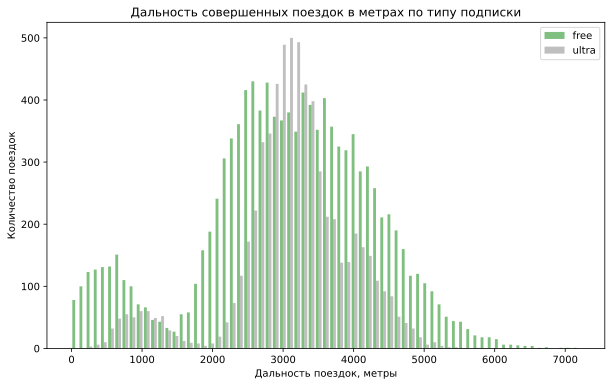

In [31]:
plt.hist([free_type['distance'], ultra_type['distance']], bins=71,
         alpha=0.5, color=['green', 'grey'], label=['free', 'ultra'])
plt.legend(loc='upper right')
plt.title('Дальность совершенных поездок в метрах по типу подписки')
plt.xlabel('Дальность поездок, метры')
plt.ylabel('Количество поездок')
plt.show()

Посмотрим гистограмму коротких поездок - до 1500 метров.

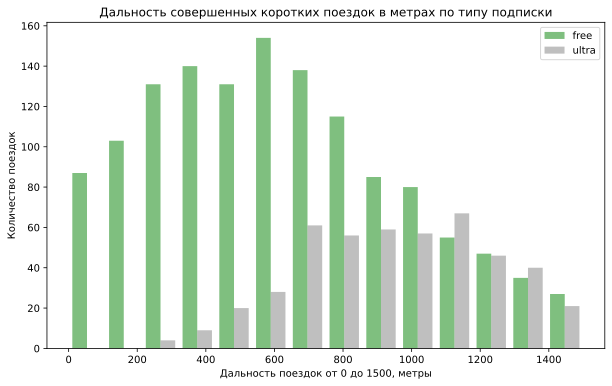

In [32]:
plt.hist([free_type['distance'], ultra_type['distance']], bins=14,
         alpha=0.5, color=['green', 'grey'], label=['free', 'ultra'], range=(0, 1500))
plt.legend(loc='upper right')
plt.title('Дальность совершенных коротких поездок в метрах по типу подписки')
plt.xlabel('Дальность поездок от 0 до 1500, метры')
plt.ylabel('Количество поездок')
plt.show()

Поездки с подпиской совершаются от 300 метров.

Поездки без подписки на короткое расстояние от 0 до 1000 метров совершаются в основном пользователями без подписки. Это не удивительно. Если человеку не понравилось ехать на самокате, или он понял, что для него это дискомфортно, то он прекратит поездку и не купит подписку.

Посмотрим на промежуток поездок от 1501 до 6000 метров.

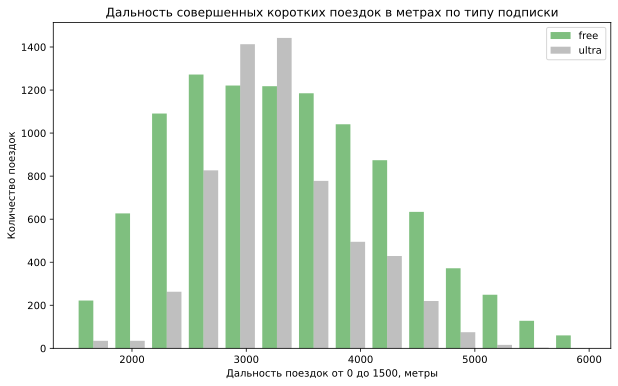

In [33]:
plt.hist([free_type['distance'], ultra_type['distance']], bins=14,
         alpha=0.5, color=['green', 'grey'], label=['free', 'ultra'], range=(1501, 6000))
plt.legend(loc='upper right')
plt.title('Дальность совершенных коротких поездок в метрах по типу подписки')
plt.xlabel('Дальность поездок от 0 до 1500, метры')
plt.ylabel('Количество поездок')
plt.show()

От 1501 до 3000 метров поездки также совершают чаще пользователи без подписки.
Поездки от 3000 до 3500 метров чаще всего совершают подьзователи с подпиской. Существенное увеличение Пользователей с подпиской начинается от дальности поездки 2800 метров до 3800 метров. И далее снижается нормально. При этом пользователей без подписки больше как на коротки дистанциях, та и на длинных, за исключением промежутка от 3000 до 3500, где больше всего пользователей с подпиской.

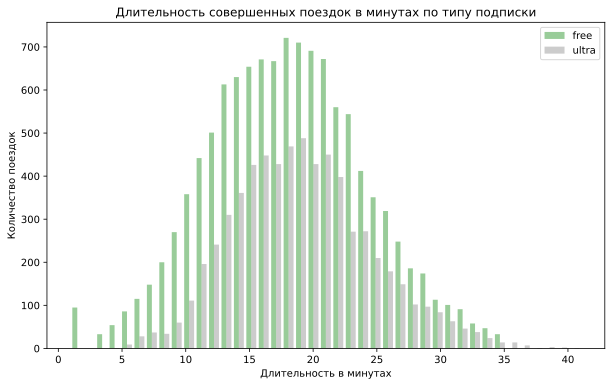

In [34]:
plt.hist([free_type['duration'], ultra_type['duration']], bins=41,\
         alpha=0.4, color=['green', 'grey'], label=['free', 'ultra'])
plt.legend(loc='upper right')
plt.title('Длительность совершенных поездок в минутах по типу подписки')
plt.xlabel('Длительность в минутах')
plt.ylabel('Количество поездок')
plt.show()


Видим нормальное распределение как для пользователей с подпиской, так и для пользователей без подписки.

Виден возможный выброс в промежутке от 0 до 5 минут для пользователей без подписки.

Если сравнивать пользователей между собой по количеству поездок и длительности, то по количеству коротких поездок  до 35 минут - лидируют пользователей без подписки. Отрезок времени с 28 минут до 35 минут - разрыв между пользователями с и без подписок уменьшается, хотя пользователи без подписки и тут в лидерах.

Видимо тех, кто пользуется самокатами нечасто много. При этот есть те, кто совершил короткую, вероятно пробную поездку, так и те, кто едет длительно по делам или в удовольствие.

Аудитория, которую можно привлечь для оплаты подписки есть.

Посмотрим, кто приносит больше выручкки.


## Исследование выручки по разным категориям пользователей.
### Создадим датафрейм с агрегированными данными о поездках на основе датафрейма data_merge.
Присвоим ему название **users_values**
Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц, переименуем столбцы:
- user_distance - суммарное расстояние для каждого пользователя за каждый месяц
- user_rides - количество поездок для каждого пользователя за каждый месяц
- user_duration - суммарное время для каждого пользователя за каждый месяц

- total_user_values - помесячная выручка,  которую принёс каждый пользователь. Для этого используем информацию об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность и дальность поездок ранее была округлена до целых чисел с помощью метода " потолок". Помесячная выручка считается по формуле: стоимость старта поездки ×  количество поездок
+ стоимость одной минуты поездки× общая продолжительность всех поездок в минутах + стоимость подписки.



In [35]:
data_merge.head()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,755,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029,27,2021-08-28,8,6,0,199


In [36]:
users_values = data_merge.pivot_table(
    index=('date_month', 'user_id'),
    values=(
    'distance', 
    'duration', 
    'minute_price', 
    'start_ride_price', 
    'subscription_fee'
    ),
    aggfunc=({'distance':{'count','sum'},
              'duration':'sum',
              'minute_price':'mean',
              'start_ride_price':'mean',
              'subscription_fee':'mean'})
)
users_values.columns = [
    'user_rides', 'user_distance', 
    'user_duration', 
    'minute_price',
    'start_ride_price', 
    'subscription_fee'
]
users_values.head(5)

user_rides  user_distance  user_duration  minute_price  \
date_month user_id                                                           
1          1                 2           7028             42             6   
           3                 1           3062             13             6   
           5                 1           3915             13             6   
           7                 2           6479             28             6   
           12                1           3578             33             6   

                    start_ride_price  subscription_fee  
date_month user_id                                      
1          1                       0               199  
           3                       0               199  
           5                       0               199  
           7                       0               199  
           12                      0               199

### Добавим информацию о выручке от каждого пользователя
Добавим столбец в датафрейм **users_values**:
- total_user_values - помесячная выручка,  которую принёс каждый пользователь. 

Для этого используем информацию об условиях оплаты для подписчиков и тех, у кого нет подписки из столбцов **minute_price,  start_ride_price,	subscription_fee**. Продолжительность и дальность поездок ранее была округлена до целых чисел с помощью метода " потолок" - содержится в столбцах **user_distance,	user_duration**. 

Помесячная выручка посчитаем по формуле: стоимость старта поездки ×  количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.
total_user_values = start_ride_price * user_rides + minute_price * user_duration + subscription_fee

In [37]:
users_values['total_user_values'] = users_values['start_ride_price'] * users_values['user_rides'] + \
users_values['minute_price'] * users_values['user_duration']+ users_values['subscription_fee']
users_values.head(5)

user_rides  user_distance  user_duration  minute_price  \
date_month user_id                                                           
1          1                 2           7028             42             6   
           3                 1           3062             13             6   
           5                 1           3915             13             6   
           7                 2           6479             28             6   
           12                1           3578             33             6   

                    start_ride_price  subscription_fee  total_user_values  
date_month user_id                                                         
1          1                       0               199                451  
           3                       0               199                277  
           5                       0               199                277  
           7                       0               199                367  
           12                      0               199                397

In [38]:
print ('Выручка за 2021 год составила по всем пользователям:', users_values['total_user_values'].sum(), 'рублей')

Выручка за 2021 год составила по всем пользователям: 3878641 рублей


In [39]:
users_values_ultra = users_values.query('subscription_fee == 199')
print('Средняя выручка от одного пользователя в месяц с подпиской равна',\
      users_values_ultra['total_user_values'].mean().round(0), 'рублей')

users_values_free = users_values.query('subscription_fee == 0')
print('Средняя выручка от одного пользователя в месяц БЕЗ подписки равна',\
      users_values_free['total_user_values'].mean().round(0), 'рублей')

Средняя выручка от одного пользователя в месяц с подпиской равна 363.0 рублей
Средняя выручка от одного пользователя в месяц БЕЗ подписки равна 329.0 рублей


Средняя месячная выручка от пользователя с подпиской больше, чем от пользователя без подписки.

## Проверка гипотез

Для проведения различных акций направленных на увеличение количества пользователей с подпиской, нужно выяснить несколько важных моментов. Для этого проверим следующие гипотезы:
- пользователи с подпиской тратят больше времени на поездки;
- среднее расстояние за одну поездку пользователя с подпиской не превышает 3130 метров;
- помесячная выручкаот пользователей с подпиской выше, чем от пользователей без подписки (по месяцам).

### Гипотеза: пользователи с подпиской тратят больше времени на поездки

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу.

Для этого используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.



Будем сравнивать данные двух дата сетов и сравнивать среднее двух генеральных совокупностей: 

- **ultra_type** -собраны данные с пользователями с типом потдписки ultra, 
- **free_type** собраны данные с пользователями с типом потдписки free.


Сформулируем гипотезы:

**H0: Среднее время   поездки пользователя с подпиской ultra равно среднему времени поездки пользователя без подписки.**
     
**H1: Среднее время   поездки пользователя с подпиской ultra больше среднего времени поездки пользователя без подписки.**

Установим:
- уровень статистической значимости в пределах конвенциальных значений alpha = 0.05
- параметр alternative='greater'

In [40]:
ultra_type.sample()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
789,86,Виталина,26,Екатеринбург,ultra,3892,22,2021-04-09,4,6,0,199


In [41]:
free_type.sample()

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
8877,878,Демид,25,Екатеринбург,free,3101,12,2021-02-01,2,8,50,0


In [42]:
#уровень стат.значимости
alpha = 0.05 

#стат.тест о равенстве длительности поездок обеих групп пользователей
results_1 = st.ttest_ind(ultra_type['duration'], free_type['duration'], alternative='greater')

print(f'p-значение: {results_1.pvalue}')

#если p-value окажется меньше alpha отвергнем гипотезу
if results_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.\nПолученное значение p-value меньше заданного уровня значимости.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')


p-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу.
Полученное значение p-value меньше заданного уровня значимости.


### Гипотеза:  среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает3130 метров

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает3130 метров? Проверим гипотезу и сделаем выводы.

Данные для проверки будут использованы из датасета **ultra_type**  в котором собраны данные с пользователями с типом подписки ultra.

Сформулируем гипотезы:

**H0: Среднее значение distance пользователей по подписке ultra равно 3130 метров**. 
     
**H1: Среднее значение distance пользователей по подписке ultra больше 3130 метров**. 

Установим:
- уровень статистической значимости в пределах конвенциальных значений alpha = 0.05
- используем в статистическом анализе параметр alternative = 'greater', поскольку оптимальное расстояние по износу составляет 3130 м, значит большее расстояние приводит к повышенному износу самоката.

In [43]:
ultra_type.sample(3)

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
2974,319,Юрий,26,Омск,ultra,3051,22,2021-07-09,7,6,0,199
791,86,Виталина,26,Екатеринбург,ultra,3099,22,2021-09-07,9,6,0,199
966,103,Святослав,28,Ростов-на-Дону,ultra,2922,14,2021-02-02,2,6,0,199


In [44]:
optimal_distance = 3130.0
alpha = 0.05
results_2 = st.ttest_1samp(ultra_type['distance'], optimal_distance, alternative='greater')

print(f'p-значение: {results_2.pvalue}')
if results_2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.\nПолученное значение p-value меньше заданного уровня значимости.')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9120422337080507
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу не получилось отвергнуть.

Можно утверждать что среднее расстояние одной поездки в метрах у пользователей с подпиской ultra, не превышает оптимальное расстояние (с точки зрения износа самоката) в 3130 метров для одной поездки. Что хорошо скажется на сроке службы самоката.

### Гипотеза:  помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Выдвинем гипотезы:

Н0: Помесячная средняя выручка от пользователей с подпиской ultra равна помесячной средней выручке от пользователей без подписки free.
                             
Н1: Помесячная средняя выручка от пользователей с подпиской ultra больше помесячной средней выручки от пользователей без подписки free.

Для проверки гипотезы используем данные датафрейма **users_values** о выручке по пользователям с подпиской ultra и без подписки free 

Данные для проверкибудут использованы из датасета ****  в котором собраны данные с пользователями с типом подписки ultra.

In [45]:
users_values.sample(3)

,,user_rides,user_distance,user_duration,minute_price,start_ride_price,subscription_fee,total_user_values
date_month,user_id,,,,,,,
12,156,2,6208,39,6,0,199,433
4,222,1,2988,15,6,0,199,289
12,1395,2,6251,33,8,50,0,364


In [46]:
# данные по пользователям с подпиской
ultra_month_value = users_values.loc[users_values['subscription_fee'] > 0, 'total_user_values']
# данные по пользователям без подписки
free_month_value = users_values.loc[users_values['subscription_fee'] == 0, 'total_user_values']

alpha = .05
results_3 = st.ttest_ind(ultra_month_value, free_month_value, alternative='greater')

print(f'p-значение: {results_3.pvalue}')    

if results_3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.\nПолученное значение p-value меньше заданного уровня значимости.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')


p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу.
Полученное значение p-value меньше заданного уровня значимости.


Можно сделать вывод, что выручка от пользователей с подпиской ultra превышает выручку полученную от пользователей без подписки. Гипотеза, которая утверждала, что помесячная средняя выручка от пользователей с подпиской ultra равна помесячной средней выручке от пользователей без подписки free была отвергнута в ходе проверки.

## Распределения

### Акция с промокодами.

Необходимо найти минимальное количество промокодов для рассылки в рамках акции с раздачей промокодов на один бесплатный месяц подписк, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. Условие- 
с вероятностью не выполнить план примерно 5%. 

Ранее акция проводилась, по итогам акции подписку продлевает 10% пользователей. После завершения периода действия подписки пользователь может от казаться от неё или продлить, совершив платеж. 
- подобрать параметры распределения, построить график распределения;
- сформулировать ответ на вопрос о количестве промокодов;

Используем юиноминальное распределение. которое описывает настоящую ситуацию.

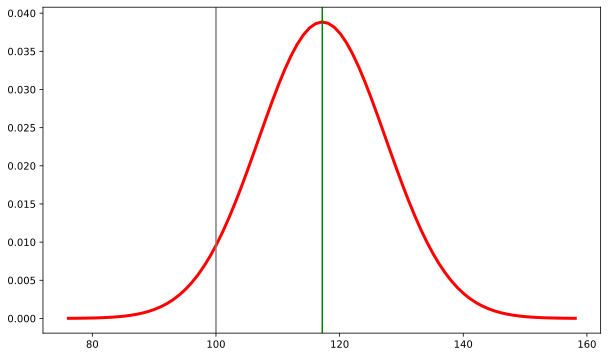

Количестве промокодов должно быть 1172.0 штук, чтобы вероятность не выполнить план была меньше 5.0 %


In [47]:
# задаем параметры биноминального распределения
n = 100 / 0.1
p = 0.1
k = 100
x = 0.05

while x < binom.cdf(k, n, p):
    n += 1

# зададим мат.ожидание и ст.отклонение нормального распределения = мат.ожиданию и ст.откл. бином. распр.
mu = n * p
sigma = (n * p * (1 - p))**0.5

result_4 = np.arange((mu - 4 * sigma),(mu + 4 * sigma),1)

plt.plot(result_4, st.norm.pdf(result_4, mu, sigma), 'r-', lw=3)
plt.axvline(x=k, color='grey')
plt.axvline(x=mu, color='green')
plt.show()

print(f'Количестве промокодов должно быть {n} штук, чтобы вероятность не выполнить план была меньше \
{binom.cdf(k, n, p).round(2)*100} %')

### Push-уведомления в мобильном приложении.
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около40 % получивших клиентов.
 Отдел планирует разослать1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более399,5 тыс. пользователей.
Подсказка
Эта ситуация описывается биномиальным распределением, воспользуемся нормальной аппроксимацией биномиального распределения и cdf() для быстрой оценки.

 

In [48]:
# задаем параметры биноминального распределения
n = 1000000
p = 0.4 
k =399500
mu = n * p
sigma = sqrt (n * p * (1 - p))
# зададим нормальное распределение
distr = st.norm(mu, sigma)

#считаем вероятность хвоста слева от 399.5тыс. (не более 399.5т)
result_5 = distr.cdf(k)
print('Вероятность того, что уведомление откроют не более399,5 тыс. пользователей:', round(result_5 * 100, 2), '%')


Вероятность того, что уведомление откроют не более399,5 тыс. пользователей: 15.37 %


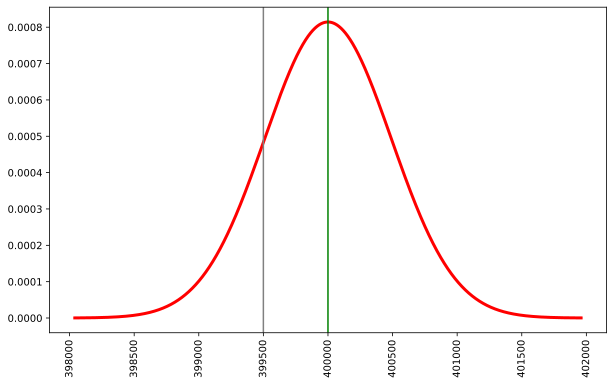

In [49]:
#границы промежутка в котором будем стоит аппороксимацию от n*p минус 4 ст.откл до n*p плюс 4 ст. откл бином распр
result_6 = np.arange((mu - 4 * sigma),(mu + 4 * sigma),1)
plt.plot(result_6, st.norm.pdf(result_6, mu, sigma), 'r-', lw=3)
plt.xticks(rotation=90)
plt.axvline(x=k, color='grey')
plt.axvline(x=mu, color='green')
plt.show()

Если 40 % клиентов откроют разосланные 1 000 000 уведомлени то вероятность того, что уведомление откроют не более 399,5 тыс. составляет  0.1537 или 15,37 %.

## Общий вывод.

Целью исследования было проверить гипотезы на основе данных, которые могут помочь бизнесу вырасти.

В основных данных содержалась информация о пользователях, их поездках и подписках. Осуществлена предобработка данных.
Выяснено, что все поездки осуществлены в пределах одного 2021 года.В столбце 'date' тип данных заменен на типу данных datetime,  удалены явные дубликаты в users_data в количестве = 31 шт. Округлили значения с помощью метода "потолок" в колонках :
distance - дистанция до метров, т.е. до целых чисел, duration - продолжительность поездки - до целых минут.
Типы данных в этих колонках после округления преобразованы в целочисленные - тип int64.

Добавлен новый столбец в датафрейм rides_data с данными о месяце поездки - 'date_month'. 

Проведен исследовательский анализ данных. 

В ходе исследования выяснено, что **по городам**:

- Пятигорск - лидер проката самокатов. Возможно это связано с тем, что город весьма холмистый.
- Екатеринбург - занимает второе место по числу проката, при этом рельеф города характеризуется чередованием низкогорья и холмистых равнин. Совпадение ли это?
- Москва - на последнем месте по числу проката самокатов. Самый плотнозаселеннный город и самое минимальное число поездок. Связано ли это с конкуренцией или более коротким сезоном проката. Возможно наличие удобного общественного транспорта в Москве влияет на такое положение дел.  

**Всего исследовано пользователей**: 1534 чел., из них:
- пользователей с подпиской:  699 чел. или  45.6 % от общего числа пользователей;
- пользователей без подписки: 835 чел. или  54.4 % от общего числа пользователей.

**Средний возраст** пользователя 25.0, максимальный возраст - 43 года, минимальный 12 лет.

В целом, возраст основных пользователей приложения от 22 лет до 28 лет. 

**Расстояние**, преодоленное пользователем за одну поездку: пик поездок приходится на поездки в 3134 метров.

Поездки с подпиской совершаются от 300 метров.

Поездки без подписки на короткое расстояние от 0 до 1000 метров совершаются в основном пользователями без подписки. Это не удивительно. Если человеку не понравилось ехать на самокате, или он понял, что для него это дискомфортно, то он прекратит поездку и не купит подписку.

От 1501 до 3000 метров поездки совершают чаще пользователи без подписки. Поездки от 3000 до 3500 метров чаще всего совершают подьзователи с подпиской. Существенное увеличение Пользователей с подпиской начинается от дальности поездки 2800 метров до 3800 метров. И далее снижается нормально. При этом пользователей без подписки больше как на коротки дистанциях, та и на длинных, за исключением промежутка от 3000 до 3500, где больше всего пользователей с подпиской.

По длительности поездок **по времени**, как и по расстоянию, исследование показало нормальное распределение как для пользователей с подпиской, так и для пользователей без подписки.

Если составить рейтинг времени поездок то он выглядит так:
- первое место занимают поездки длительностью 19 или 18 минут;
- второе место разделили поездки длительностью 21, 16 и 20 минут;
- третье место поездки 17 минут.

По количеству коротких поездок  до 35 минут - лидируют пользователей без подписки. Отрезок времени с 28 минут до 35 минут - разрыв между пользователями с и без подписок уменьшается, хотя пользователи без подписки и тут в лидерах.

Самая длительная поездка - 41 минута.

Вероятен выброс в промежутке от 0 до 5 минут для пользователей без подписки. Короткие поездки в одну минуту - почти 100. Причина короткой поездки может быть в том, что пользователь передумал совершать поездку, либо в неисправности самоката.

Тех, кто пользуется самокатами нечасто  - много. При этот есть те, кто совершил короткую, вероятно пробную поездку, так и те, кто едет длительно по делам или в удовольствие.

**Вывод:** Аудитория, которую можно привлечь для оплаты подписки есть - большое число пользователей без подписки.

**Выручка** за 2021 год составила по всем пользователям: 3878641 рублей:
- Средняя выручка от одного пользователя в месяц с подпиской равна 363 рубля.
- Средняя выручка от одного пользователя в месяц БЕЗ подписки равна 329 рублей.

Средняя месячная выручка от пользователя с подпиской больше, чем от пользователя без подписки.

**Проверка гипотез.**

**Гипотеза: пользователи с подпиской тратят больше времени на поездки**.

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.
нулевая гипотеза:  Среднее время   поездки пользователя с подпиской ultra равно среднему времени поездки пользователя без подписки 
альтернативная гипотеза:  Среднее время   поездки пользователя с подпиской ultra больше среднего времени поездки пользователя без подписки.

В ходе проверки нулевую гипотезу отвергли. Что означает, что отрицать нельзя того, что среднее время   поездки пользователя с подпиской ultra больше среднего времени поездки пользователя без подписки.  

**Гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.**

Проверили гипотезы, где:
- Нулевая гипотеза это - Среднее значение расстояния пользователей по подписке ultra равно 3130 метров.
- Альтернативная гипотеза это -  Среднее значение расстояния пользователей по подписке ultra больше 3130 метров.

Не получилось отвергнуть нулевую гипотезу, а это значит, что можно сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. Это расстояние оптимальное с точки зрения износа самокатов. Пользователи с подпиской в среднем проезжают оптимальное расстояние. Это бережет самокаты от износа.

Что хорошо скажется на сроке службы самоката.

**Гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.**

Проверили гипотезы, где:
- Нулевая гипотеза - звучит так: Помесячная средняя выручка от пользователей с подпиской ultra равна посмесячной средней выручке от пользователей без подписки free.
- Альтернативная гипотеза Помесячная средняя выручка от пользователей с подпиской ultra больше помесячной средней выручки от пользователей без подписки free.

В ходе проверки, нулевая гипотеза была отвергнута.

Можно сделать вывод, что выручка от пользователей с подпиской ultra превышает выручку полученную от пользователей без подписки. Гипотеза, которая утверждала, что помесячная средняя выручка от пользователей с подпиской ultra равна помесячной средней выручке от пользователей без подписки free была отвергнута в ходе проверки.

**Распределения** 

**Акция с промокодами.**

Необходимо было найти минимальное количество промокодов для рассылки в рамках акции с раздачей промокодов на один бесплатный месяц подписк, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. Условие- с вероятностью не выполнить план примерно 5%. Ранее акция проводилась, по итогам акции подписку продлевает 10% пользователей. После завершения периода действия подписки пользователь может отказаться от неё или продлить, совершив платеж.

**Количестве промокодов должно быть не менее 1172 штук, чтобы вероятность не выполнить план была меньше 5.0 %**

**Push-уведомления в мобильном приложении.**

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около40 % получивших клиентов. Отдел планирует разослать1 млн уведомлений. 
В ходе проверки, выснено, что если 40 % клиентов откроют разосланные 1 000 000 уведомлений, то вероятность того, что уведомление откроют не более 399,5 тыс. **составляет 0.1537 или 15,37 %.**
